In [44]:
import pandas as pd
import numpy as np
from time import sleep
from scipy.linalg import expm,logm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pylab import *
from tqdm import tqdm

In [ ]:
#基金池
df_codes=pd.read_csv('./Data/codes.csv',index_col=0)
codes=list(df_codes['code'].values)

#计算月度收益率
df_nav=pd.read_csv('./Data/nav.csv')
df_nav.set_index('time')
df_nav['mon']=df_nav['time'].apply(lambda x:int(x/100))
months=set(df_nav['mon'].values)
df_nav.drop_duplicates(subset=['mon'], keep='last', inplace=True)
df_nav.drop(columns=['time'],inplace=True)
df_nav=df_nav[df_nav['mon']>=201601]

cols=list(df_nav.columns)
cols.pop(-1)
for col in cols:
    col_name=col
    df_nav[col_name]=df_nav[col]/df_nav[col].shift()

df_mon=df_nav.reset_index(drop=True)
df_mon.set_index('mon',inplace=True)
df_mon.fillna(1,inplace=True)

'''等权'''

N=len(codes)
EW=np.array([round(1/N,4)]*N)
EW.shape=[30,1]

mons=list(df_mon.index)
mat_nav=np.array(df_mon.values)
#每月收益率矩阵
ew_ret=np.dot(mat_nav,EW)

shape_0=ew_ret.shape[0]
ew_ret.shape=[1,shape_0]
ew_ret=np.cumprod(ew_ret)

df_ret=pd.DataFrame(ew_ret,index=mons,columns=['ew_ret'])
df_ret.reset_index(inplace=True)
df_ret.rename(columns={'index':'mon'},inplace=True)
df_ret['mon']=df_ret['mon'].astype(str)
df_ret.set_index('mon',inplace=True)
mons=list(df_ret.index)

'''市值加权'''

#对数市值
df_value=pd.read_csv('./Data/value.csv')
df_value.set_index('time',inplace=True)

#计算均衡权重
df_value['sum']=df_value.sum(axis=1)
for code in codes:
    df_value[code]=df_value[code]/df_value['sum']

weight=np.array(df_value[codes][df_value.index==20181231])
weight=weight*100
weight=np.round(weight,2)
mat_weight=weight.reshape(30,1)

VW=mat_weight/100
vw_ret=np.dot(mat_nav,VW)
vw_ret.shape=[1,shape_0]
vw_ret=np.cumprod(vw_ret)

In [ ]:
'''BL权重'''

def BL(first,last):
    #收益率计算
    df_nav_tmp=df_nav[df_nav.index>=first]
    df_nav_tmp=df_nav_tmp[df_nav_tmp.index<=last]
    df_pct=df_nav_tmp.shift()/df_nav_tmp
    df_pct.reset_index(inplace=True)
    df_pct.drop(index=[0],inplace=True)
    df_pct.set_index('time',inplace=True)
    # df_pct.drop(columns=['index'],inplace=True)
   
    #计算协方差矩阵
    mat_cov=np.array(df_pct.cov())*100
    codes=list(df_pct.columns)

    #计算均衡收益率
    Pi=np.dot(mat_cov,mat_weight)

    #回归生成主观观点
    def regress(name):
        #计算各时间窗口的MA
        t_list=[5,7,10]
        def MA(name,t):
            df_tmp=pd.DataFrame(df_nav_tmp[name])
            df_tmp.rename(columns={name:'price'},inplace=True)
            df_tmp['mon']=df_tmp.index/100
            df_tmp['mon']=df_tmp['mon'].apply(lambda x:int(x))

            def moving_avg(df_raw,t):
                price_list=np.array(df_raw['price'])
                return np.average(price_list[-t:])/price_list[-1]
            return df_tmp.groupby('mon').apply(moving_avg,t)
        
        df_0=pd.DataFrame(MA(name,t_list[0]))
        df_0.rename(columns={0:t_list[0]},inplace=True)

        for i in range(1,len(t_list)):
            df_1=pd.DataFrame(MA(name,t_list[i]))
            df_1.rename(columns={0:t_list[i]},inplace=True)
            df_0=pd.merge(df_0,df_1,how='left',left_index=True,right_index=True)

        #计算月度收益率
        df_tmp=pd.DataFrame(df_nav_tmp[name])
        df_tmp.rename(columns={name:'price'},inplace=True)
        df_tmp['mon']=df_tmp.index/100
        df_tmp['mon']=df_tmp['mon'].apply(lambda x:int(x))
        df_1=pd.DataFrame(df_tmp.groupby('mon').apply(lambda x:x['price'].iloc[-1]/x['price'].iloc[0]))
        df_1.rename(columns={0:'mon_avg'},inplace=True)
        df_0=pd.merge(df_0,df_1,how='left',left_index=True,right_index=True)

        #多元线性回归
        cols=df_0.columns
        df_0=(df_0-1)*100

        X=df_0[cols[:-1]]
        Y=df_0[cols[-1]]

        model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)
        model.fit(X, Y)   # 线性回归建模
        predict=model.intercept_
        r_square=model.score(X,Y)

        return predict,r_square
    
    predict_list=[]
    r_list=[]
   
    for code in codes:
        predict,r_square=regress(code)
        predict_list.append(predict)
        r_list.append(r_square)

    #BL模型参数设置
    T=0.025
    p=np.array([1]*30)
    P=np.diag(p)
    Q=np.array(predict_list)
    Q.shape=(30,1)

    #确定观点协方差矩阵omega

    #根据因子值修改主观观点
    # df_a=pd.pivot_table(df_4de,index='time',columns='code',values='进攻')
    # df_d=pd.pivot_table(df_4de,index='time',columns='code',values='防守')
    # df_e=pd.pivot_table(df_4de,index='time',columns='code',values='经验')
    # df_s=pd.pivot_table(df_4de,index='time',columns='code',values='规模')

    # mons_tmp=list(df_a.index)
    # i=0
    # while i < len(mons_tmp):
    #     if mons_tmp[i]>last:
    #         break
    #     else:
    #         i+=1
    # def get_multiplier(mon):
    #     A=np.array(df_a[df_a.index==mon].T.values)
    #     D=np.array(df_d[df_d.index==mon].T.values)
    #     E=np.array(df_e[df_e.index==mon].T.values)
    #     S=np.array(df_s[df_s.index==mon].T.values)
    #     multipllier=(D-A+E+S)/100-1
    #     multipllier.shape=[1,30]
    #     multipllier=np.diag(multipllier[0])
    #     multipllier=expm(multipllier)
    #     return multipllier
    # multipliler=get_multiplier(mons_tmp[i-1])

    omega=np.diag(r_list)
    omega=omega/100

    #确定后验收益率均值
    x1=np.linalg.inv(T*mat_cov)
    x2=np.dot(np.dot(P.T,np.linalg.inv(omega)),P)
    y1=np.linalg.inv(x1+x2)
    x3=np.dot(x1,Pi)
    x4=np.dot(np.dot(P.T,np.linalg.inv(omega)),Q)
    y2=x3+x4
    mu=np.dot(y1,y2)
    #确定后验收益率协方差
    sigma=mat_cov+y1
    w=np.dot(np.linalg.inv(sigma),mu)

    mu=np.round(mu,2)
    w=np.round(w,2)
    #无法做空，权重不小于0
    for i in range(len(w)):
        if w[i] < 0:
            w[i]=0
    return w

df_nav=pd.read_csv('./Data/nav.csv',index_col=0)
df_nav.reset_index(inplace=True)

df_nav['mon']=df_nav['time'].apply(lambda x:int (x/100))
df_nav.dropna(axis=0,how='any',inplace=True)
last=list(df_nav[['time','mon']].groupby('mon').last().values)
first=list(df_nav[['time','mon']].groupby('mon').first().values)
df_nav.drop(columns=['mon'],inplace=True)
df_nav.set_index('time',inplace=True,drop=True)


bl_ret=[]
w_list=[]
months=list(df_mon.index)

for i in tqdm(range(len(months))):
    w=BL(first[i][0],last[i+11][0])
    w=w/100
    nav_tmp=mat_nav[i]
    ret=np.dot(nav_tmp,w)
    # 权重和调整至100%
    if w.sum()<1:
        ret+=1-w.sum()
    if w.sum()>1:
        s=w.sum()
        for i in range(len(w)):
            w[i]=w[i]/s
        ret=np.dot(nav_tmp,w)
    w_list.append(w)
    bl_ret.append(ret[0])


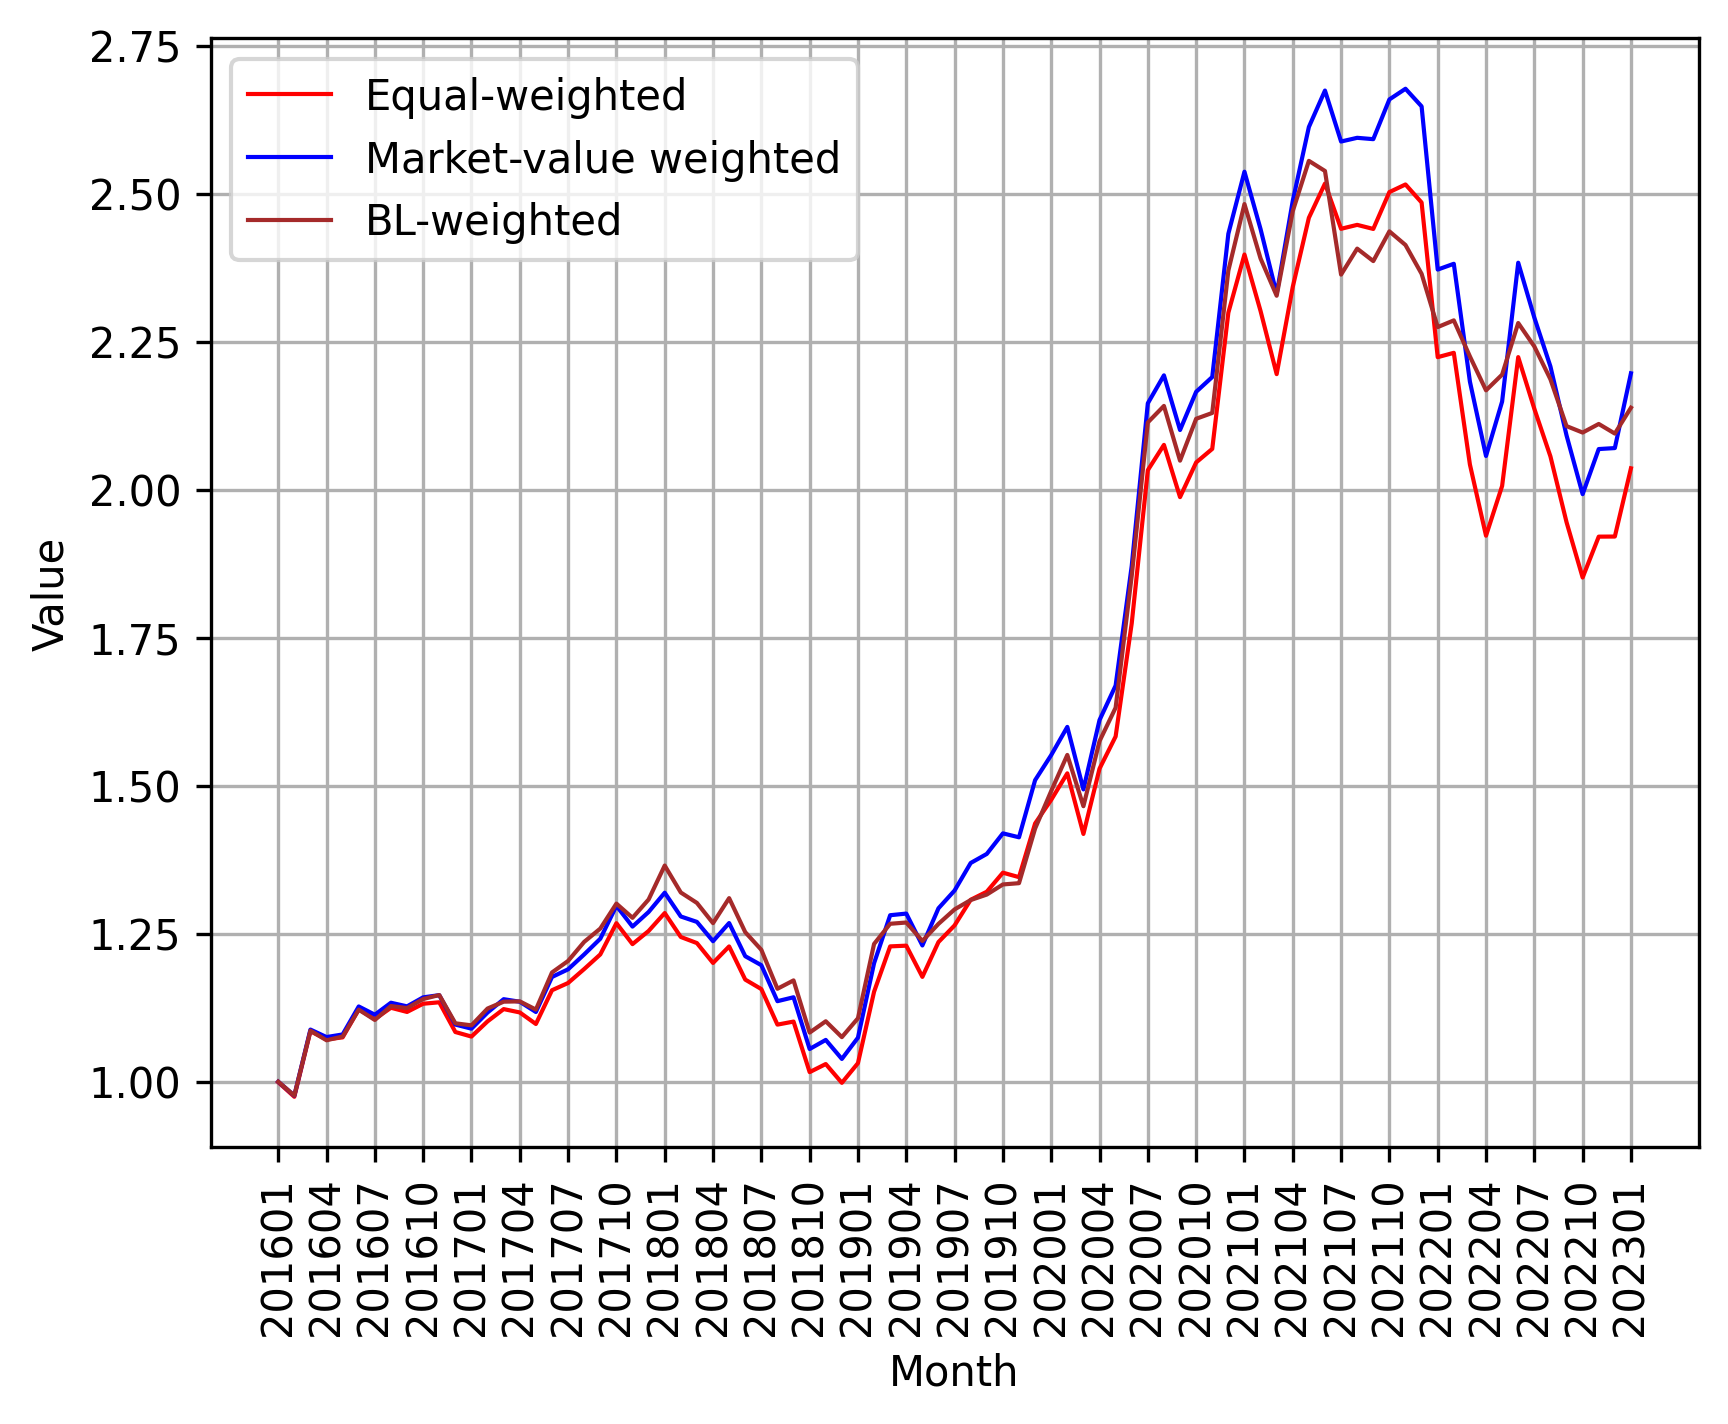

In [48]:
ret_final=np.cumprod(bl_ret)
plt.figure(dpi=300)
plt.figure(1)
plt.plot(mons,ew_ret,color='r',linewidth=1,label='Equal-weighted')
plt.plot(mons,vw_ret,color='b',linewidth=1,label='Market-value weighted')
# plt.plot(mons,attri_ret,color='black',linewidth=1,label='Multi-factor weighted')
plt.plot(mons,ret_final,color='brown',linewidth=1,label='BL-weighted')
plt.grid()

xticks = list(range(0, len(mons), 3))
xlabels = [str(mons[x]) for x in xticks]
plt.xticks(rotation=90)
plt.xticks(ticks=xticks, labels=xlabels)
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend(loc=0)
plt.show()


In [42]:
# df_4demension=pd.read_excel('./Data/基金四维度得分.xlsx',index_col=0)
# df_4de=df_4demension[df_4demension['code'].isin(codes)]
# df_4de=df_4de[df_4de['time']>=20151231]
# df_4de['sum']=df_4de['进攻']+df_4de['防守']+df_4de['规模']+df_4de['经验']
# df_tmp=pd.pivot_table(df_4de,index='time',columns='code',values='sum')
# df_tmp['sum']=df_tmp[cols].sum(axis=1)

# for col in list(df_tmp.columns):
#     if col != 'sum':
#         df_tmp[col]=df_tmp[col]/df_tmp['sum']
# df_tmp.reset_index(inplace=True)
# df_tmp['mon']=df_tmp['time'].apply(lambda x:int (x/100))
# df_tmp.set_index('mon',inplace=True)
# df_tmp.drop(columns=['time','sum'],inplace=True)

In [46]:
# months=list(df_mon.index)
# mon_tmp=list(df_tmp.index)
# attri_ret=[]
# for i in range(len(months)):
#     j=0
#     while j+1  < len(mon_tmp):
#         if months[i] >= mon_tmp[j]:
#             j+=1
#         else:
#             break

#     nav_tmp=mat_nav[i]
#     wei_tmp=np.array(df_tmp[df_tmp.index==mon_tmp[j]].values)
#     wei_tmp.shape=[30,1]
#     ret_tmp=np.dot(nav_tmp,wei_tmp)

#     # print (ret_tmp)
#     attri_ret.append(ret_tmp)
# attri_ret=np.array(attri_ret)
    
# attri_ret=np.cumprod(attri_ret)